In [303]:
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [353]:
def data_retrieval(sourcefile, metadata, pt_id):

	'''
	This function reads data for a single patient from a master spreadsheet with amplicon data for all plates/patients.
	Input is the sourcefile with the readcounts (allele_counts_anon), and a metadata file which contains cell type for each plate (Amplicon_metadata_fixed_anon.xlsx).
	The function returns a dataframe containing just the data for the specified patient, ready to merge with index data and then plot.
	'''

	df = pd.read_csv(sourcefile, header = [0,1,2], index_col = 0, sep='\t')
	df = df.stack([0,1,2])
	df = df.reorder_levels([1,0,2,3])
	df = df.to_frame()  #puts everything back in a dataframe
	df.columns = ['Reads']
	df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
	df['Well'] = df.index.get_level_values(1)
	df['Amplicon'] = df.index.get_level_values(2)
	df['Genotype'] = df.index.get_level_values(3)
	df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
	df = df.drop(columns = ['one', 'two'])

	#Import information about plate cell type and patient
	key = pd.read_excel(metadata, sheet_name = 'PlateID') #should this be an input? also in next fucntion
	key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
	key.rename(columns = {'Comments2':'Plate'}, inplace = True)
	key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

	#Make a dictionary to associate plates with patients and plate with cell type
	plate_pt_dict = dict(zip(key.Plate, key.Patient))
	plate_cell_dict = dict(zip(key.Plate, key.Celltype))

	#Now just look at data from selected patient, and apply filters to identify cells with enough reads/amplicon
	pt_allele_plate = df.loc[df['Patient'].isin([pt_id])] 
	pt_allele_plate = pt_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
	pt_allele_plate['Cell_type'] = pt_allele_plate['Plate'].replace(plate_cell_dict)
	pt_allele_plate['Plate_Well'] = pt_allele_plate['Plate'].astype(str) + '_' + pt_allele_plate['Well'].astype(str)

	return pt_allele_plate

In [438]:
def calc_scVAF(data, pt_init, reads):
    
    '''
    This function takes amplicon read counts for mt and wt and calculates the proportion of mutated alleles in each cell that meets the specified read count.
    Not sure this is the best method though, the second function calc_scVAF_binary_per_cell() is aligned to method for calling haps
    '''
    
    cond = pt_init
    print(cond)
    
    if cond == 'JP001':  #cols is the columns actually being used, can be easily tweaked
        #cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a']
        cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_g']
        allcols = ['JP001_RUNX1_c','JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_c','JP001_TET2b_g']
    elif cond == 'PD7153':
        cols = ['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']
        allcols = ['PD7153_CUX1', 'PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b', 'PD7153_TGFB3_c', 'PD7153_TGFB3_g']
    elif cond == 'PD7151': 
        cols = ['PD7151_TET2a', 'PD7151_TET2b']
        allcols = ['PD7151_TET2a', 'PD7151_TET2b']
        
    else:
        print('Enter JP001,  PD7153, or PD7151 as pt_id')
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Group the data and apply filters
    df = data.copy()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = allcols
    
    df = df.loc[(df[cols] >= reads).all(axis=1)] #df1 contains just the rows with cells we want - use this to create a filter or key
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
    wells = df['Plate_Well'].drop_duplicates().to_list() 
    print(f'Cells with {reads} reads  = ', len(wells))

    df2 = data.copy()
    df2 = df2[df2['Plate_Well'].isin(wells)]
    df2 = df2[df2['Amplicon'].isin(cols)]
    
    #Calculate the allele frequency
    df2 = df2.iloc[:, 0:1].unstack(level = 3)
    df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
    df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']
    

    #Assign Wt or MT to each allele
    df2 = df2.drop(columns = ['Reads', 'Total'])
    df2 = df2.unstack(2)
    df2.columns = cols


    df2['Sort_cell_type'] = df2.index.get_level_values(0)
    df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
    df2['Plate'] = df2.index.get_level_values(0)
    df2['Well'] = df2.index.get_level_values(1)
    df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
    df2 = df2.drop(columns = ['Plate', 'Well'])
    
    rename = {'CD34+halfCD38-': 'CD34', 'CD34+/38-':'CD34', 'CD34+':'CD34'}
    df2['Sort_cell_type'].replace(rename, inplace = True)
    df2.sort_values(by=['Sort_cell_type'], inplace = True)
    
    x = df2.copy().groupby(by = 'Sort_cell_type').mean()
    x = x.unstack().to_frame()
    x['celltype'] = x.index.get_level_values(1)
    x['Amplicon'] = x.index.get_level_values(0)
    co = ['VAF', 'sort_celltype', 'Amplicon']
    x.columns = co
    x.sort_values(by=['sort_celltype'], inplace = True)
    
    all_amps = ['JP001_SRSF2',
            'PD7153_TET2b',
            'JP001_TET2a',
            'PD7153_TET2a', 
            'PD7151_TET2b',
            'JP001_TET2b_g', 
            'PD7153_SRSF2', 
            'JP001_RUNX1_g',
            'PD7153_CUX1',
            'PD7151_TET2a'
           ]
    colors = sns.color_palette('husl', n_colors = len(all_amps))
    allVAFcols = dict(zip(all_amps, colors))

    fig, ax = plt.subplots(figsize = (2.5,4))
    sns.scatterplot(x = 'sort_celltype', y = 'VAF', data = x, s = 100,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax)
    ax.legend(loc = 'upper left', bbox_to_anchor = [1,1], title = 'scVAFs by read frequency')
    ax.set_ylim(0,0.6)
    ax.axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation = 90)
    
    return x

def calc_scVAF_binary_per_cell(data, pt_init, reads, cutoff):
    
    '''
    This function takes amplicon read counts for mt and wt and calculates whether a given cell does (1) or does not (0) contain a mutant allele, based on the desired read count and cutoff values.
    '''
    
    cond = pt_init
    print(cond)
    
    if cond == 'JP001':  #cols is the columns actually being used, can be easily tweaked
        #cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a']
        cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_g']
        allcols = ['JP001_RUNX1_c','JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_c','JP001_TET2b_g']
    elif cond == 'PD7153':
        cols = ['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']
        allcols = ['PD7153_CUX1', 'PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b', 'PD7153_TGFB3_c', 'PD7153_TGFB3_g']
    elif cond == 'PD7151': 
        cols = ['PD7151_TET2a', 'PD7151_TET2b']
        allcols = ['PD7151_TET2a', 'PD7151_TET2b']
        
    else:
        print('Enter JP001,  PD7153, or PD7151 as pt_id')
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Group the data and apply filters
    df = data.copy()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = allcols
    
    df = df.loc[(df[cols] >= reads).all(axis=1)] #df1 contains just the rows with cells we want - use this to create a filter or key
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
    wells = df['Plate_Well'].drop_duplicates().to_list() 
    print(f'Cells with {reads} reads  = ', len(wells))

    df2 = data.copy()
    df2 = df2[df2['Plate_Well'].isin(wells)]
    df2 = df2[df2['Amplicon'].isin(cols)]
    
    #Calculate the allele frequency
    df2 = df2.iloc[:, 0:1].unstack(level = 3)
    df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
    df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']
    
    #Assign Wt or MT to each allele
    df2 = df2.drop(columns = ['Reads', 'Total'])

    conditions = [(df2['Mut_freq'] <= cutoff), (df2['Mut_freq']) > cutoff ]
    values = [0, 1]
    df2['Genotype'] = np.select(conditions, values)
    df2 = df2.drop(columns = ['Mut_freq']).unstack(2)
    df2.columns = cols


    df2['Sort_cell_type'] = df2.index.get_level_values(0)
    df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
    df2['Plate'] = df2.index.get_level_values(0)
    df2['Well'] = df2.index.get_level_values(1)
    df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
    df2 = df2.drop(columns = ['Plate', 'Well'])
    
    rename = {'CD34+halfCD38-': 'CD34', 'CD34+/38-':'CD34', 'CD34+':'CD34'}
    df2['Sort_cell_type'].replace(rename, inplace = True)
    df2.sort_values(by=['Sort_cell_type'], inplace = True)
    
    cells = df2['Sort_cell_type'].drop_duplicates().to_list()
    heads = ['Sort_cell_type', 'Amplicon', 'n_mut', 'vaf', 'total']
    data = pd.DataFrame(columns = heads)
    for c in cells:
        df4 = df2.loc[df2['Sort_cell_type'].isin([c])]
        data2 = {}
        for co in cols:
            tot = len(df4[co])
            n_mut = df4[co].sum()     
            vaf = n_mut/tot
            sers = [c, co, n_mut, vaf, tot]
            df5 = pd.Series(data=sers, index = heads)
            data = data.append(df5, ignore_index = True)

    data.sort_values(by=['Amplicon'], inplace = True)
    data.sort_values(by=['Sort_cell_type'], inplace = True)
    
    all_amps = ['JP001_SRSF2',
            'PD7153_TET2b',
            'JP001_TET2a',
            'PD7153_TET2a', 
            'PD7151_TET2b',
            'JP001_TET2b_g', 
            'PD7153_SRSF2', 
            'JP001_RUNX1_g',
            'PD7153_CUX1',
            'PD7151_TET2a'
           ]
    colors = sns.color_palette('husl', n_colors = len(all_amps))
    allVAFcols = dict(zip(all_amps, colors))
    
    fig, ax = plt.subplots(figsize = (2.5,4))
    sns.scatterplot(x = 'Sort_cell_type', y = 'vaf', data = data, s = 100,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax)
    ax.legend(loc = 'upper left', bbox_to_anchor = [1,1], title = 'scVAFs by wt/mt status')
    ax.set_ylim(0,1.1)
    #ax.axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.6, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.7, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.8, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.9, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(1.0, ls = '--', c = 'silver', zorder = 0)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation = 90)
    
    
    return data

PD7151
Cells with 10 reads  =  1207
PD7151
Cells with 10 reads  =  1207


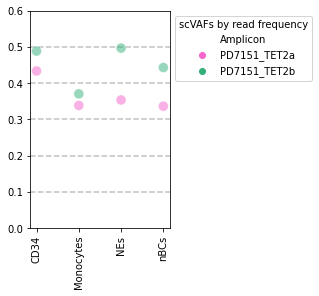

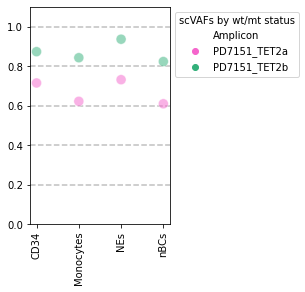

In [439]:
sourcefile = '../Data/Amp_data/allele_counts_anon.tsv'
metadata = '../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx'
pt_id = 'PD7151'
plate = data_retrieval(sourcefile, metadata, pt_id)
reads = 10
plate2a = calc_scVAF(plate, pt_id, reads)
cutoff = 0.1
plate3a = calc_scVAF_binary_per_cell(plate, pt_id, reads, cutoff)

PD7153
Cells with 10 reads  =  1177
PD7153
Cells with 10 reads  =  1177


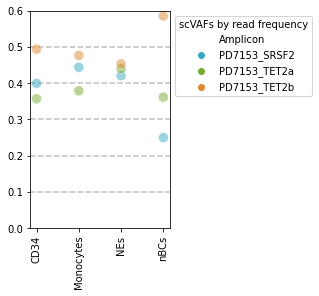

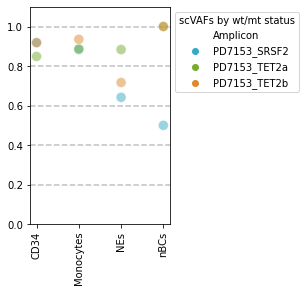

In [440]:
pt_id = 'PD7153'
plate = data_retrieval(sourcefile, metadata, pt_id)
reads = 10
plate2b = calc_scVAF(plate, pt_id, reads)
cutoff = 0.1
plate3b = calc_scVAF_binary_per_cell(plate, pt_id, reads, cutoff)

JP001
Cells with 10 reads  =  253
JP001
Cells with 10 reads  =  253


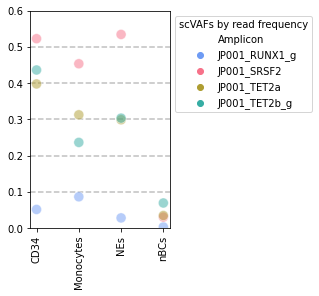

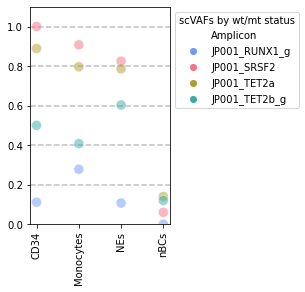

In [441]:
pt_id = 'JP001'
plate = data_retrieval(sourcefile, metadata, pt_id)
reads = 10
plate2c = calc_scVAF(plate, pt_id, reads)
cutoff = 0.1
plate3c = calc_scVAF_binary_per_cell(plate, pt_id, reads, cutoff)

In [442]:
frames = [plate3a, plate3b, plate3c]
plate3_all = pd.concat(frames)

pt_test = []
for index, row in plate3_all.iterrows():
    pt_test.append(row['Amplicon'].split('_')[0])

plate3_all['Pt'] = pt_test


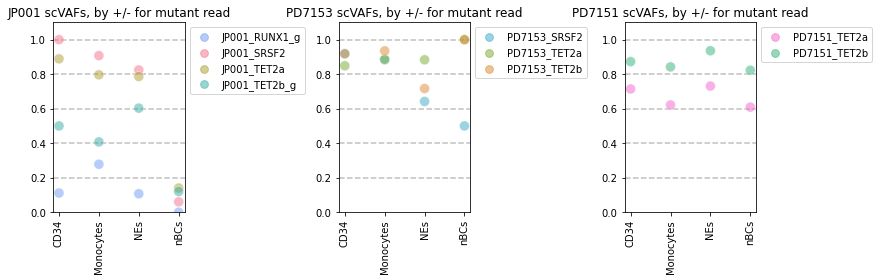

In [462]:
#plate3_all.sort_values(by=[['Sort_cell_type','Amplicon']], inplace = True)
pts = ['JP001', 'PD7153', 'PD7151']

all_amps = ['JP001_SRSF2',
        'PD7153_TET2b',
        'JP001_TET2a',
        'PD7153_TET2a', 
        'PD7151_TET2b',
        'JP001_TET2b_g', 
        'PD7153_SRSF2', 
        'JP001_RUNX1_g',
        'PD7153_CUX1',
        'PD7151_TET2a'
       ]
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

fig, ax = plt.subplots(1, 3, figsize = (12,4))
for count, pt in enumerate(pts):
    sns.scatterplot(x = 'Sort_cell_type', y = 'vaf', data = plate3_all.loc[plate3_all['Pt'].isin([pt])], s = 100,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels()    
    lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [1,1], markerscale = 1.3, handles=handles[1:], labels=labels[1:])
    ax[count].set_ylim(0,1.1)
    #ax.axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.7, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.8, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.9, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(1.0, ls = '--', c = 'silver', zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax[count].set_title(f'{pt} scVAFs, by +/- for mutant read')
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)
fig.tight_layout()    
fig.savefig('../Results/sc_byhapcuts_VAFs.png',bbox_inches='tight', dpi = 300)

In [444]:
frames = [plate2a, plate2b, plate2c]
plate2_all = pd.concat(frames)

pt_test = []
for index, row in plate2_all.iterrows():
    pt_test.append(row['Amplicon'].split('_')[0])

plate2_all['Pt'] = pt_test

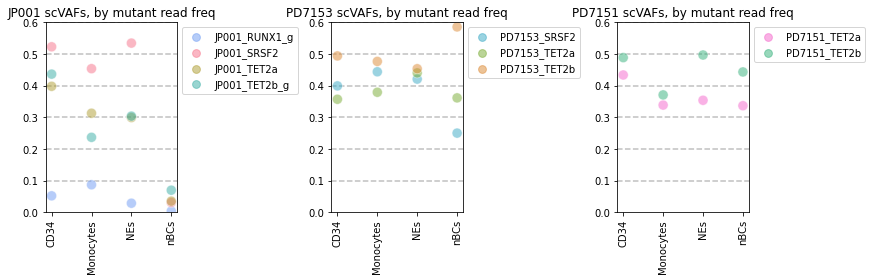

In [463]:
pts = ['JP001', 'PD7153', 'PD7151']

all_amps = ['JP001_SRSF2',
        'PD7153_TET2b',
        'JP001_TET2a',
        'PD7153_TET2a', 
        'PD7151_TET2b',
        'JP001_TET2b_g', 
        'PD7153_SRSF2', 
        'JP001_RUNX1_g',
        'PD7153_CUX1',
        'PD7151_TET2a'
       ]
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

fig, ax = plt.subplots(1, 3, figsize = (12,4))
for count, pt in enumerate(pts):
    sns.scatterplot(x = 'sort_celltype', y = 'VAF', data = plate2_all.loc[plate2_all['Pt'].isin([pt])], s = 100,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels()    
    lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [1,1], markerscale = 1.3, handles=handles[1:], labels=labels[1:])
    ax[count].set_ylim(0,0.6)
    ax[count].axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(0.7, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(0.8, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(0.9, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(1.0, ls = '--', c = 'silver', zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax[count].set_title(f'{pt} scVAFs, by mutant read freq')
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)
    
fig.tight_layout()    
fig.savefig('../Results/sc_byreadfreq_VAFs.png',bbox_inches='tight', dpi = 300)